# Sparkify Project

As a fictional music streaming service, Sparkify is looking to predict which of it's users are most likely to stop using the service in the future. When users stop using the service it is a loss of potential revenue; users leaving a service is commonly called churn.

The data provided is time series event data, it's a long format dataset that has a record for each event. Each record also contains some metadata about the user and session in addition to the type of event. The project goal can be easily summarized as: **predict the users who will churn based on the events data**. 

Solving this will entail first exploring the dataset, then engineering features, and finally building a model. Exploring the dataset will probably be the majority of the project in terms of length, since we have to build a good understanding of the patterns before we move on.

We then will have to use those insights to write a script that transforms the event data into a features table to feed into the models. The features table should have userIds on one axis and a variety of features that can be used to split them on the other. Since there are far fewer churned users than normal users, the f1-score will be a good metric for evaluating the models. So the final solution will be a set of functions for cleaning and processing the raw data followed by a model that is effective at making the predictions. 

This notebook is based on a subset (128MB) of the full dataset available (12GB). It contains exploration and intial feature engineering, model training and conclusions are in the next notebook. I'll start with some imports and create the local spark session.

I don't expect this project to be the most rigourous, I was mostly going to familiarize myself with PySpark as a tool for data processing.

In [1]:
# import libraries
from pyspark.sql import SparkSession

import pyspark.sql.functions as sf
import pyspark.sql.types as st

from matplotlib import pyplot as plt
import seaborn as sns

from pyspark.ml.feature import VectorAssembler

sns.set_style('whitegrid')
# %matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Initial Exploration") \
    .getOrCreate()

# Load and Clean Dataset
Clean your dataset, checking for invalid or missing data. For example, records without userids or sessionids. In this workspace, the filename is `mini_sparkify_event_data.json`.

In [3]:
df_raw = spark.read.json('mini_sparkify_event_data.json')
df_raw.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

Now let's check out the fields that are available and try to describe the ones that seem relevant.

In [4]:
df_raw.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Alright so here there's some clearly important features:
- userId: Identifies unique users
- sessionId: Identifies unique sessions for a user
- page: The type of the event
- ts: unix timestamp of the event
- registraction: the timestamp of when the user registered for the platfore

There are a few other features that are probably related to the song that was played (artist, song, length etc). And other than that there a few more features that relate to the specifics of the user/session (location, iteminsession, names) that might also be useful.

Now let's check out how many records we have in the dataset.

In [7]:
df_raw.count()

286500

287k, not bad!

Now I want to move on to checking data ingegrity, the first place to start is to look for missing values. 

Code inspired by https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe

In [4]:
missing = df_raw.select([sf.count(sf.when(sf.isnull(c), c)).alias(c) for c in df_raw.columns]).toPandas().T
missing.columns = ['null_count']
missing

,null_count
artist,58392
auth,0
firstName,8346
gender,8346
itemInSession,0
lastName,8346
length,58392
level,0
location,8346
method,0


Well, there's actually quite a few missing values in some of these columns. The ones that have a lot of missing values seem to be missing song data, it's likely these are just for events that are not the song play event. The missing user and session information is pretty bad though, it's worth investigating that a bit. Interestingly there's no missing userIds, let's see what those are in that case.

In [9]:
df_raw.where(sf.isnull(df_raw.registration)).select('userId').distinct().show()

+------+
|userId|
+------+
|      |
+------+



Wow, it look's like it's just empty string for those userIds.

In [10]:
df_raw.count() - df_raw.filter(df_raw.userId != "").count()

8346

And the count matches the number of missing values! Let's just get rid of those records since we won't be able to associate them with a user as we want.

In [21]:
df = df_raw.filter(df_raw.userId != "")
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [11]:
# TODO - check null session IDs in full data
#df = df_raw.filter(df_raw.sessionId != "")

# Exploratory Data Analysis
Here we will first check out some high level features of the dataset - then define churn, and then check out some features related to churned and non-churned users!



### Explore Data - High Level
First we can look at the types of events that are available, the time range of the dataset, the number of users etc.

In [22]:
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

Let's look at some sample values from most columns so we understand what we are looking at. Starting with a bunch of string columns we can see that they probably won't be too useful for distinguishing users. User agent could be really interesting but would require a lot of work to decode it.

In [34]:
df.select(['artist', 'song', 'firstName', 'lastName', 'location', 'userAgent']).limit(9).show(10)

+--------------------+--------------------+---------+--------+--------------------+--------------------+
|              artist|                song|firstName|lastName|            location|           userAgent|
+--------------------+--------------------+---------+--------+--------------------+--------------------+
|      Martha Tilston|           Rockpools|    Colin| Freeman|     Bakersfield, CA|Mozilla/5.0 (Wind...|
|    Five Iron Frenzy|              Canada|    Micah|    Long|Boston-Cambridge-...|"Mozilla/5.0 (Win...|
|        Adam Lambert|   Time For Miracles|    Colin| Freeman|     Bakersfield, CA|Mozilla/5.0 (Wind...|
|              Enigma|Knocking On Forbi...|    Micah|    Long|Boston-Cambridge-...|"Mozilla/5.0 (Win...|
|           Daft Punk|Harder Better Fas...|    Colin| Freeman|     Bakersfield, CA|Mozilla/5.0 (Wind...|
|The All-American ...|      Don't Leave Me|    Micah|    Long|Boston-Cambridge-...|"Mozilla/5.0 (Win...|
|The Velvet Underg...|         Run Run Run|    Micah|  

Next we will move on through the other string features that only take on a few values:

In [25]:
df.select('auth').distinct().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



Auth is probably not too useful.

In [26]:
df_raw.select('level').distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



Level is how we would distinguish the free and paid sessions of users - we will discuss this a little bit later on in the project.

In [27]:
df_raw.select('status').distinct().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



Status could be pretty interesting, perhaps certain statuses relate to errors.

In [28]:
df_raw.select('method').distinct().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



Method is unlikely to be useful. Next we can move on to a few of the numerical features, starting with song length.

In [29]:
df.select('length').describe().show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



Looks like this let's us get access to some descriptive statistics about song length. There might be some clever feature that could be extracted here, like how often people skip a song - but that would be really challenging. itemInSession is technically a numerical feature but a standard analysis isn't too useful. It just tells the number position of the event within a single session.

In [30]:
df.select('itemInSession').describe().show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            278154|
|   mean|114.89918174824018|
| stddev|  129.851729399489|
|    min|                 0|
|    max|              1321|
+-------+------------------+



Next we can take a look at the two timestamp features, registration and ts. It looks like they are in unix or ns format so we'll have to clean that up later.

In [33]:
df.select(['registration', 'ts']).limit(5).show()

+-------------+-------------+
| registration|           ts|
+-------------+-------------+
|1538173362000|1538352117000|
|1538331630000|1538352180000|
|1538173362000|1538352394000|
|1538331630000|1538352416000|
|1538173362000|1538352676000|
+-------------+-------------+



Finally we can move on to the user and session ids, which are numeric features but should really act like strings since they are unique ids.

In [32]:
df.select(['userId', 'sessionId']).limit(5).show()

+------+---------+
|userId|sessionId|
+------+---------+
|    30|       29|
|     9|        8|
|    30|       29|
|     9|        8|
|    30|       29|
+------+---------+



First let's check the number of sessions and users in the subset.

In [12]:
df.agg(sf.countDistinct('userId'), sf.countDistinct('sessionId')).show()

+----------------------+-------------------------+
|count(DISTINCT userId)|count(DISTINCT sessionId)|
+----------------------+-------------------------+
|                   225|                     2312|
+----------------------+-------------------------+



Finally we can move on to the page feature which is the most important.

In [122]:
pages = df.select('page').distinct().sort('page')
pages.toPandas()

,page
0,About
1,Add Friend
2,Add to Playlist
3,Cancel
4,Cancellation Confirmation
5,Downgrade
6,Error
7,Help
8,Home
9,Logout


Wow, now we should see which ones are most frequent.

In [24]:
event_counts = df.groupby('page').count().sort('count', ascending=False).toPandas().set_index('page')
event_counts

,count
page,
NextSong,228108
Thumbs Up,12551
Home,10082
Add to Playlist,6526
Add Friend,4277
Roll Advert,3933
Logout,3226
Thumbs Down,2546
Downgrade,2055


Wow the song related event is by far the most common. The others are still going to be really useful, but there will probably have to be a bunch of features built using the song events!

Text(0,0.5,'Event Name')

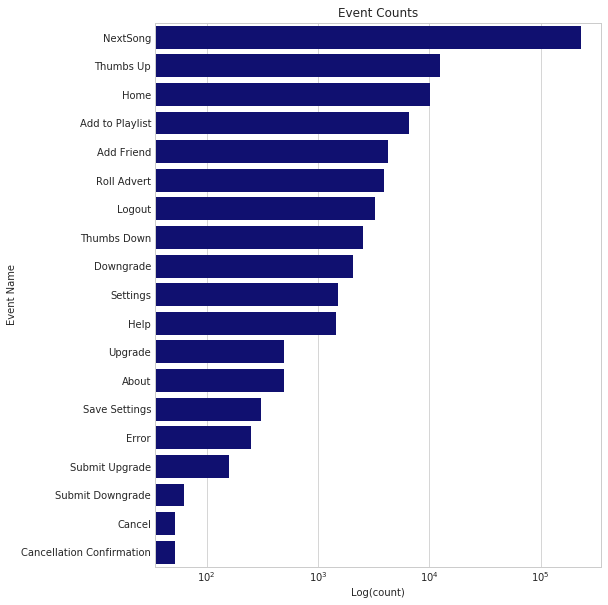

In [83]:
plt.figure(figsize=(8,10))

g = sns.barplot(
    x=event_counts['count'],
    y=event_counts.index,
    color='navy',
    log=True
)

g.set_title('Event Counts')
g.set_xlabel('Log(count)')
g.set_ylabel('Event Name')

Taking a look at the log of the event count makes it even more clear that the song related events are way ahead, and the other more negative events including Errors, Cancellation, and Downgrade are all way more rare. Now let's convert the timestamp features to a more easy to use format.

In [8]:
def convert_ms(x):
    """Converts given ns to ms"""
    if x is None:
        return None
    
    return x//1000

convert_ms_udf = sf.udf(convert_ms, st.LongType())

df = df.withColumn('timestamp', convert_ms_udf(df.ts).cast('timestamp'))
df = df.withColumn('registration_ts', convert_ms_udf(df.registration).cast('timestamp'))

df.select('ts', 'timestamp', 'registration', 'registration_ts').show(5)

+-------------+-------------------+-------------+-------------------+
|           ts|          timestamp| registration|    registration_ts|
+-------------+-------------------+-------------+-------------------+
|1538352117000|2018-10-01 00:01:57|1538173362000|2018-09-28 22:22:42|
|1538352180000|2018-10-01 00:03:00|1538331630000|2018-09-30 18:20:30|
|1538352394000|2018-10-01 00:06:34|1538173362000|2018-09-28 22:22:42|
|1538352416000|2018-10-01 00:06:56|1538331630000|2018-09-30 18:20:30|
|1538352676000|2018-10-01 00:11:16|1538173362000|2018-09-28 22:22:42|
+-------------+-------------------+-------------+-------------------+
only showing top 5 rows



Now we can check out the range of registrations and the time window of the events that we have available.

In [17]:
df.agg(sf.min('timestamp'), sf.max('timestamp')).show()

+-------------------+-------------------+
|     min(timestamp)|     max(timestamp)|
+-------------------+-------------------+
|2018-10-01 00:01:57|2018-12-03 01:11:16|
+-------------------+-------------------+



In [18]:
df.agg(sf.min('registration_ts'), sf.max('registration_ts')).show()

+--------------------+--------------------+
|min(registration_ts)|max(registration_ts)|
+--------------------+--------------------+
| 2018-03-18 13:44:35| 2018-11-26 15:49:14|
+--------------------+--------------------+



Now we can add a function to make some time plots a little easier.

In [45]:
def plot_time_counts(df, page=None, agg='day', by_field=None):
    """
    Function to aggregate by date and get the resulting counts. Displays the resulting line plot.
    
    Parameters:
        df (PySpark Dataframe): Input Dataframe
        page (str): Optional, input an event to limit the count to just that event
        agg (str): Optional, input a date or time trunc type to change the granularity
        by_field (str)): Optional, input a field to aggregate by that too
        
    Returns:
        None
    """
    if page is not None:
        plot_df = df.where(df.page==page)
    else:
        plot_df = df
    
    if by_field is None:
        group = sf.date_trunc(agg, plot_df.timestamp).alias(agg)
    elif by_field is not None:
        group = [sf.date_trunc(agg, plot_df.timestamp).alias(agg), by_field]
        
    daily_counts = plot_df.groupby(group).count().sort(agg).toPandas()
    
    plt.figure(figsize=(12,6))
    ax = sns.lineplot(x=agg, 
                     y='count', 
                     hue=by_field, 
                     data=daily_counts)
    plt.xticks(rotation=30, ha="right")

#     ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


Now we can plot the daily event counts to check for patterns

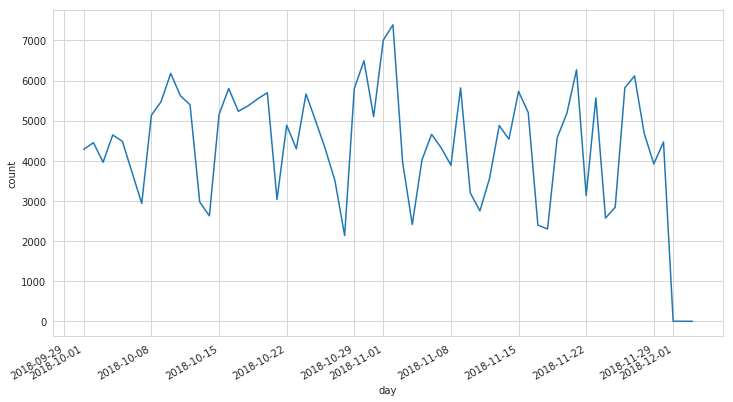

In [46]:
plot_time_counts(df)

We can see the pattern in the day of the week! Probably won't be useful to distinguish users but it's interesting. Also seems like the last events are a bit of a mistake. We can define another useful plotting function now to look at user distributions.

In [132]:
def plot_field_count_dist(df, field, page=None):
    """
    Plots the distribution of a given field
    
    Arguments:
        df (Spark DataFrame): the input dataframe
        field (str): The field to graph the distribution of
        page (str): Optional, limits the distribution to a single page
    """
    if page is not None:
        plot_df = df.where(df.page==page)
    else:
        plot_df = df
    
    field_counts = plot_df.groupby(field).count().toPandas()
    
    sns.distplot(field_counts['count'], 
                 kde=False, 
                 bins=20)
    
    return field_counts

First we can look at the distribution of the number of events by user. It looks like there's a long tail but it's a power distribution.

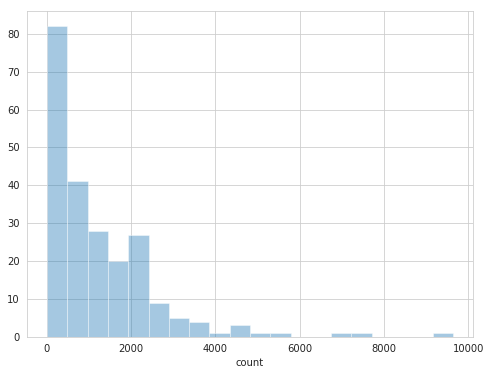

In [74]:
plt.figure(figsize=(8,6))
user_counts = plot_field_count_dist(df, 'userId')

In [26]:
user_counts['count'].describe()

count     225.000000
mean     1236.240000
std      1329.531716
min         6.000000
25%       296.000000
50%       848.000000
75%      1863.000000
max      9632.000000
Name: count, dtype: float64

The distribution of events per session looks similar although slightly less dramatic.

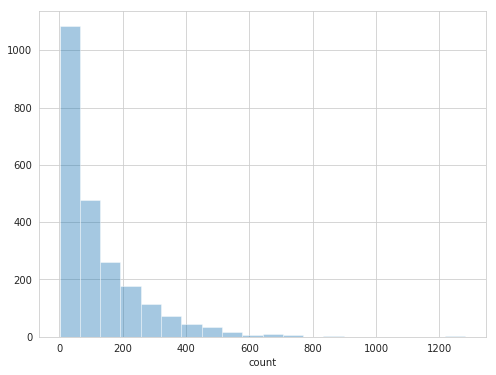

In [65]:
plt.figure(figsize=(8,6))
session_counts = plot_field_count_dist(df, 'sessionId')

In [66]:
session_counts['count'].describe()

count    2312.000000
mean      120.308824
std       134.407683
min         1.000000
25%        28.000000
50%        72.000000
75%       169.000000
max      1282.000000
Name: count, dtype: float64

### Define Churn

Now we have to figure out what event or pattern of events will count as churn. After looking at a few examples I settled on using `Cancellation Confirmation` events, although `Submit Downgrade` would also be interesting too look at in the future.

First we confirm that cancellation confirmation can occur with both free and paid users which gives it a minor advantage in predicting churn.

In [24]:
df.where(df.page=='Cancellation Confirmation').select(['page', 'timestamp', 'userId', 'sessionId', 'level']).show(10)

+--------------------+-------------------+------+---------+-----+
|                page|          timestamp|userId|sessionId|level|
+--------------------+-------------------+------+---------+-----+
|Cancellation Conf...|2018-10-07 20:26:30|    18|      514| paid|
|Cancellation Conf...|2018-10-08 21:10:46|    32|      540| paid|
|Cancellation Conf...|2018-10-12 04:35:18|   125|      174| free|
|Cancellation Conf...|2018-10-12 20:17:21|   105|      508| paid|
|Cancellation Conf...|2018-10-13 21:19:44|    17|      797| paid|
|Cancellation Conf...|2018-10-15 07:34:14|   143|      843| free|
|Cancellation Conf...|2018-10-16 22:30:37|   101|      842| paid|
|Cancellation Conf...|2018-10-17 00:29:21|   129|      802| paid|
|Cancellation Conf...|2018-10-17 07:02:29|   121|      881| paid|
|Cancellation Conf...|2018-10-17 07:39:32|    51|      934| paid|
+--------------------+-------------------+------+---------+-----+
only showing top 10 rows



Now let's look at an eventstream for a user that hit's `Cancellation Confirmation`.

In [32]:
df.where((df.userId==121) &
         (df.timestamp>'2018-10-17 06:35:23')).sort('ts').select('timestamp', 'page','sessionId', 'level').show()

+-------------------+--------------------+---------+-----+
|          timestamp|                page|sessionId|level|
+-------------------+--------------------+---------+-----+
|2018-10-17 06:35:39|     Add to Playlist|      881| paid|
|2018-10-17 06:39:24|            NextSong|      881| paid|
|2018-10-17 06:39:25|           Downgrade|      881| paid|
|2018-10-17 06:42:28|            NextSong|      881| paid|
|2018-10-17 06:42:29|           Thumbs Up|      881| paid|
|2018-10-17 06:46:50|            NextSong|      881| paid|
|2018-10-17 06:51:17|            NextSong|      881| paid|
|2018-10-17 06:56:09|            NextSong|      881| paid|
|2018-10-17 07:02:06|            NextSong|      881| paid|
|2018-10-17 07:02:18|           Downgrade|      881| paid|
|2018-10-17 07:02:19|              Cancel|      881| paid|
|2018-10-17 07:02:29|Cancellation Conf...|      881| paid|
+-------------------+--------------------+---------+-----+



Looks like the session always ends with the cancellation confirmation event, that's super interesting. It looks like once that event happens the user is just totally gone. That's why this is a good event to use for our definition of churn. Now just for completeness let's look at a downgrade event.

In [31]:
df.where((df.userId==131) & 
         (df.timestamp>'2018-11-19 23:23:15') & 
         (df.timestamp<'2018-11-20 00:15:09')).sort('ts').select('timestamp', 'page','sessionId', 'level').show()

+-------------------+----------------+---------+-----+
|          timestamp|            page|sessionId|level|
+-------------------+----------------+---------+-----+
|2018-11-19 23:26:00|        NextSong|     2041| paid|
|2018-11-19 23:31:02|        NextSong|     2041| paid|
|2018-11-19 23:34:49|        NextSong|     2041| paid|
|2018-11-19 23:43:52|        NextSong|     2041| paid|
|2018-11-19 23:46:25|        NextSong|     2041| paid|
|2018-11-19 23:51:15|        NextSong|     2041| paid|
|2018-11-19 23:51:36|       Downgrade|     2041| paid|
|2018-11-19 23:51:37|Submit Downgrade|     2041| paid|
|2018-11-19 23:52:00|            Home|     2041| free|
|2018-11-19 23:54:39|        NextSong|     2041| free|
|2018-11-19 23:59:05|        NextSong|     2041| free|
|2018-11-20 00:03:59|        NextSong|     2041| free|
|2018-11-20 00:07:03|        NextSong|     2041| free|
|2018-11-20 00:10:56|        NextSong|     2041| free|
+-------------------+----------------+---------+-----+



It's exactly as we would expect - the user goes from paid to free. I'm not going to look at those in this project but it would be a really interesting extension.

Next we'll set up our data to investigate churned v non-churned users.

In [16]:
churn_users = df.where(df.page=='Cancellation Confirmation').select('userId').toPandas().userId.tolist()

df = df.withColumn('churn', df.userId.isin(churn_users))

Now let's use the functions set up earlier to check out the segmented data. First let's look at event counts.

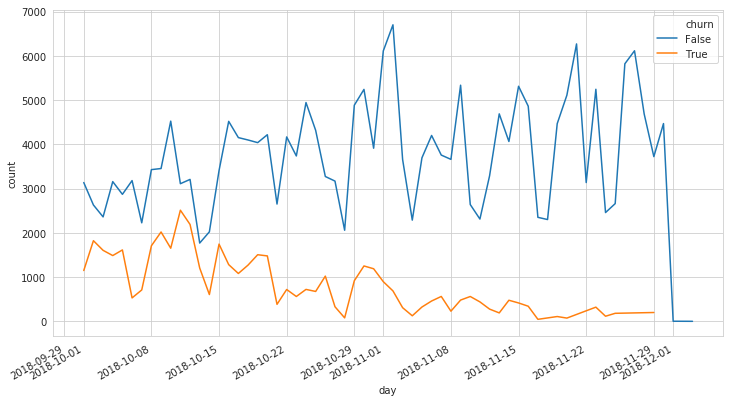

In [47]:
plot_time_counts(df, by_field='churn')

Churned users show a decrease in total events which is expected since they leave after the churn event. The engagement of non-churn users seems to go up as time goes on, this could be a useful pattern!

Now I'm curious about the time distribution of the churn events, maybe they are frontloaded?

In [37]:
week_fn = sf.date_trunc('week', df.timestamp).alias('week')

week_counts = df.where(df.page=='Cancellation Confirmation').groupby(week_fn).count().sort('week').toPandas()

In [50]:
week_counts.set_index('week', inplace=True)

In [64]:
import datetime

[Text(0, 0, '2018-10-01'),
 Text(0, 0, '2018-10-08'),
 Text(0, 0, '2018-10-15'),
 Text(0, 0, '2018-10-22'),
 Text(0, 0, '2018-10-29'),
 Text(0, 0, '2018-11-05'),
 Text(0, 0, '2018-11-12'),
 Text(0, 0, '2018-11-19'),
 Text(0, 0, '2018-11-26')]

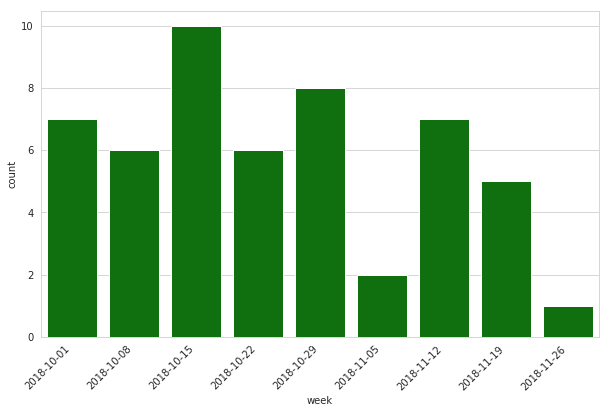

In [78]:
plt.figure(figsize=(10,6))
ax = sns.barplot(
        x=week_counts.index,
        y=week_counts['count'],
        color='green'
)

# ax.set_xlim(left=datetime.date(2018, 10, 1), right=datetime.date(2018, 12, 4))
x_dates = week_counts.index.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

Looks like the churn events are slightly frontloaded but not as bad as I thought. There are still a good number of churn events later in the dataset. Next let's see if different users have different account ages, based on registration. First I want to check if there are any users that register during our event period.

In [99]:
min_timestamp = df.select(sf.min('timestamp')).first()[0]

In [106]:
df.where(df.registration_ts > min_timestamp).select('userId', 'churn', 'registration_ts').distinct().count()

5

In [108]:
df.where(df.registration_ts > min_timestamp).select('userId', 'churn', 'registration_ts').distinct().show()

+------+-----+-------------------+
|userId|churn|    registration_ts|
+------+-----+-------------------+
|   152|false|2018-10-30 23:03:28|
|   154|false|2018-11-03 18:00:21|
|   155|false|2018-11-04 22:27:50|
|   153|false|2018-11-03 05:42:17|
|   156|false|2018-11-26 15:49:14|
+------+-----+-------------------+



Interestingly there are 5 users that did register during the event period! It's small enough that it probably won't affect the model but it's nice to know. Now we can compare churn/non-churn user age.

In [27]:
max_user_ages = df.select('userid', 'churn', sf.datediff(df.timestamp, df.registration_ts).alias('age')) \
                                    .groupby('userid', 'churn').max()

In [30]:
max_user_ages.groupby('churn').mean().show()

+-----+-----------------+
|churn|    avg(max(age))|
+-----+-----------------+
| true|57.36538461538461|
|false|86.56647398843931|
+-----+-----------------+



Seems like churned users tend to have been around for less time, interesting! Now let's move on to comparing counts of different kinds of event for churn/non-churn users. We will start with song plays.

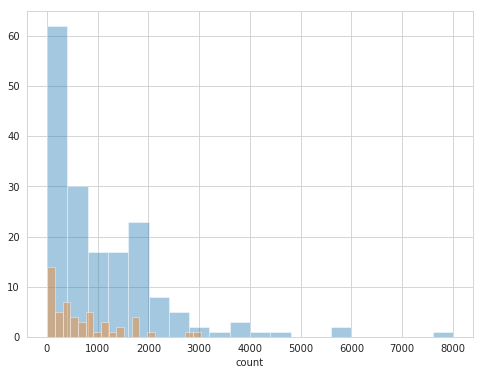

In [82]:
plt.figure(figsize=(8, 6))
no_churn_song_counts = plot_field_count_dist(df.where(~df.churn), 'userId', page='NextSong')
churn_song_counts = plot_field_count_dist(df.where(df.churn), 'userId', page='NextSong')

In [83]:
churn_song_counts.describe()

,count
count,52.000000
mean,699.884615
std,714.737650
min,8.000000
25%,148.750000
50%,452.500000
75%,963.500000
max,3028.000000


In [84]:
no_churn_song_counts.describe()

,count
count,173.000000
mean,1108.173410
std,1183.146703
min,3.000000
25%,251.000000
50%,747.000000
75%,1640.000000
max,8002.000000


Seems like churned users have a fewer songs played on average.

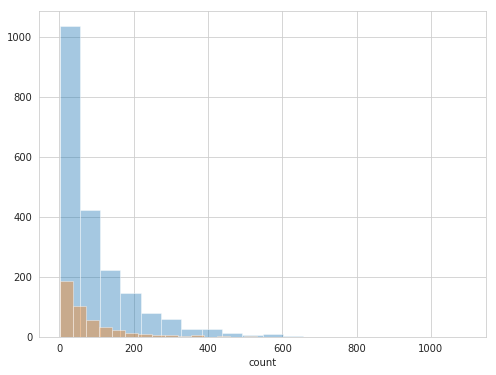

In [98]:
plt.figure(figsize=(8, 6))
_ = plot_field_count_dist(df.where(~df.churn), 'sessionId', page='NextSong')
_ = plot_field_count_dist(df.where(df.churn), 'sessionId', page='NextSong')

Taking a look at session counts it seems like churned users also have fewer sessions! Let's try to compute some event type averages by user and by session. First let's look at the number of users and sessions in each group.

In [110]:
churn_counts = df.groupby('churn').agg(sf.countDistinct('userId'), sf.countDistinct('sessionId')).toPandas()
churn_counts.columns = ['churn', 'user_count', 'session_count']
churn_counts

,churn,user_count,session_count
0,True,52,468
1,False,173,2110


Now we'll get some counts that will be useful for the next section.

In [111]:
by_churn_event_counts = df.groupby(['churn', 'page']).count().toPandas()

In [112]:
by_churn_counts = by_churn_event_counts.merge(churn_counts, on='churn')

In [113]:
by_churn_counts.head()

,churn,page,count,user_count,session_count
0,False,Save Settings,252,173,2110
1,False,Submit Downgrade,54,173,2110
2,False,NextSong,191714,173,2110
3,False,Add Friend,3641,173,2110
4,False,Error,220,173,2110


With those counts we can get session normalized and user normalized event counts, useful to compare churned and non-churned users.

In [114]:
by_churn_counts = by_churn_counts[~by_churn_counts.page.isin(['Cancellation Confirmation', 'Cancel'])]

In [115]:
by_churn_counts['user_normalized'] = by_churn_counts['count'] / by_churn_counts['user_count']
by_churn_counts['session_normalized'] = by_churn_counts['count'] / by_churn_counts['session_count']

In [116]:
by_churn_counts[['churn', 'page', 'user_normalized', 'session_normalized']].sort_values(by=['page', 'churn'])

,churn,page,user_normalized,session_normalized
6,False,About,2.537572,0.208057
32,True,About,1.076923,0.119658
3,False,Add Friend,21.046243,1.725592
29,True,Add Friend,12.230769,1.358974
5,False,Add to Playlist,31.722543,2.600948
23,True,Add to Playlist,19.961538,2.217949
15,False,Downgrade,9.930636,0.814218
30,True,Downgrade,6.480769,0.720085
4,False,Error,1.271676,0.104265
35,True,Error,0.615385,0.068376


Now first we can take a look at the user counts:

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

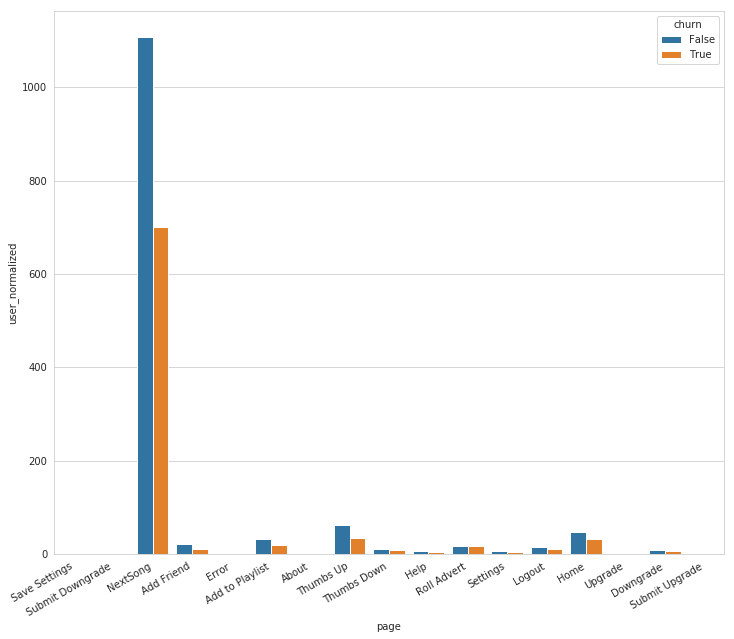

In [117]:
event_subset = []

plt.figure(figsize=(12,10))
sns.barplot(x='page',
            y='user_normalized',
            hue='churn',
            data=by_churn_counts)
plt.xticks(rotation=30, ha="right")

Well, it seems like the churned users have fewer events in general as we knew already. Interestingly, the churned users have WAY fewer songs, and MORE ads by a teeny fraction. On to the per session averages.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

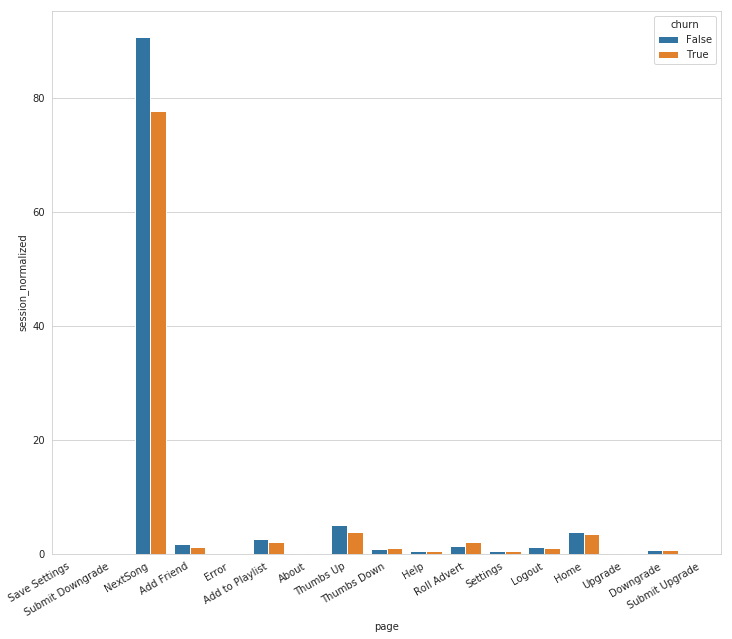

In [118]:
plt.figure(figsize=(12,10))
sns.barplot(x='page',
            y='session_normalized',
            hue='churn',
            data=by_churn_counts)
plt.xticks(rotation=30, ha="right")

The per session averages look similar to the per user - except the difference in ad views per session is more obvious. Let's see if we can get a better vizualization of this phenomenon.

In [119]:
def plot_relative(df, col):
    df_2 = df.pivot(index='page', columns='churn', values=col)
    
    plot_df = (df_2[True] - df_2[False]).divide(df_2[False]) + 1
    
    ax = sns.barplot(x=plot_df.index, 
                    y=plot_df, 
                    color= '#6699ff')
    ax.axhline(1, ls='--')


This function will give a plot of the relative value of the churn vs non-churn users, 1 is identical to the churned users.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

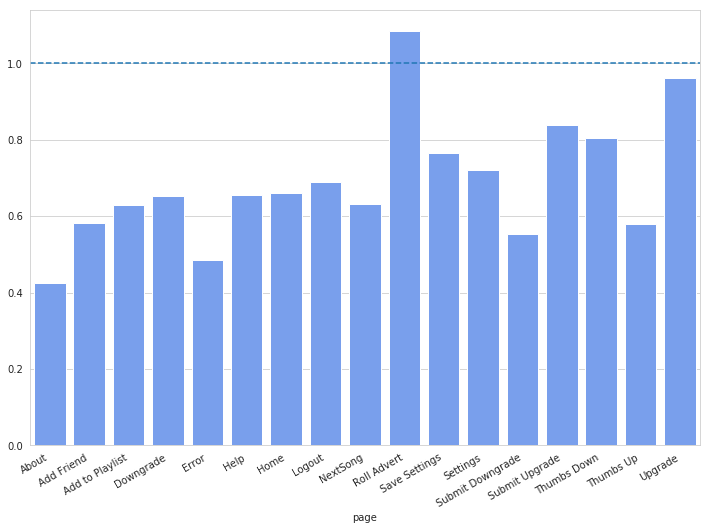

In [120]:
plt.figure(figsize=(12,8))
plot_relative(by_churn_counts, 'user_normalized')
plt.xticks(rotation=30, ha="right")

This shows the pattern in a way easier to understand vizual. Lower almost accross the board except for ads!

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

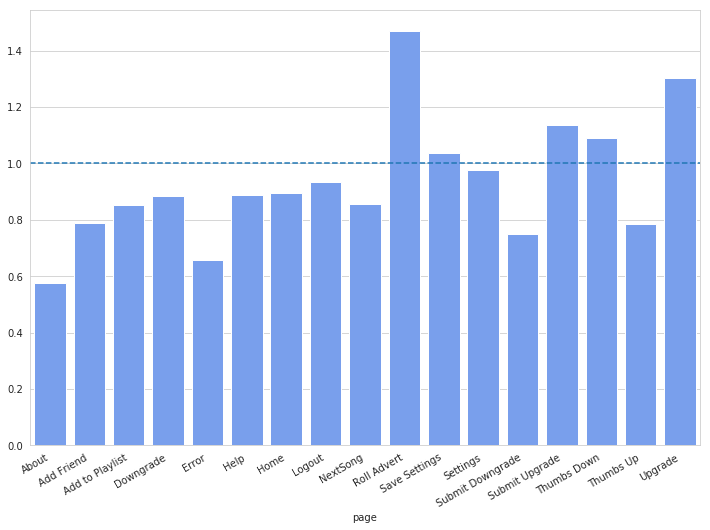

In [124]:
plt.figure(figsize=(12,8))
plot_relative(by_churn_counts, 'session_normalized')
plt.xticks(rotation=30, ha="right")

The session normalized one is even more interesting! There might be a few patterns here that are useful to distinguish the users between churn and non-churn. Especially the slightly higher thumbs down and much higher roll ads.

### Exploration Takeaways

We can sum up what we found with a few high level takeaways:

* Churned users decrease activity over time.
* Churned users have lower session counts and activity in general.
* Churned users tend to be younger accounts.
* Churned users likely have more ads per session.

We can use these findings to make some useful features for classification!

# Feature Engineering
Now that we've found some patterns in the data we are goint to write a short script that can clean the raw data and then extract some features. To start we take some cleaning steps taken during the exploration so it's easy to restart if needed.

In [7]:
def convert_ms(x):
    """Converts given ns to ms"""
    if x is None:
        return None
    
    return x//1000

convert_ms_udf = sf.udf(convert_ms, st.LongType())

In [43]:
def clean_df(df_raw):
    """
    Takes in a raw events dataframe, makes a few extra columns and cleans it.
    """
    
    # Remove bad userIds
    df = df_raw.filter(df_raw.userId != "")
    df.persist()
    
    # Clean time columns
    df = df.withColumn('timestamp', convert_ms_udf(df.ts).cast('timestamp'))
    df = df.withColumn('registration_ts', convert_ms_udf(df.registration).cast('timestamp'))
    
    return df

In [ ]:
# after reading in the df just running this cell catches up with the exploration
df = clean_df(df_raw)

pages = df.select('page').distinct().sort('page')
pages_list = [r.page for r in pages.collect()]

Now we've got the clean data, we can move on to engineering some features. I'm going to step through some example parts of the code to explain what the feature is before we get to the whole function. The snippets won't contain everything, just the essential bits to understand a feature. The full code is at the end in the `get_feature_df` function.

### Number of sessions
The first feature is simple, the number of sessions for each user.
```
session_counts = df.groupby('userId').agg(sf.countDistinct('sessionId').alias('session_count'))
```

### Session-normalized user event averages
As we saw in the final step of the exploration, we can distinguish users based on their average event counts per session. That's what this feature is, we will use the `Cancellation Confirmation` as the label. First we have to get a column for each event count which can be accomplished easily with pivot:
```
pages_list = [r.page for r in pages.collect()]
drop_events = ['Cancel']

feat_df = df.groupby('userId').pivot('page', pages_list).count()
feat_df = feat_df.withColumnRenamed('Cancellation Confirmation', 'churn')
feat_df = feat_df.drop(*drop_events).fillna(0)
```

This code accomplished a few other things, like providing the events as a list to speed up the function and filling all missing counts with 0.

To finish up we will session normalize the remaining columns:
```
remaining_cols = sorted(list(set(feat_df.columns) - ignore_cols))
for column in remaining_cols:
    feat_df = feat_df.withColumn(column, sf.col(column) / feat_df.session_count)
```

### Account ages
This one is pretty simple - similar to exploration we will calculate the account ages.
```
 max_timestamp = df.agg(sf.max('timestamp')).first()[0]
 account_ages = df.select('userId', 
                       sf.datediff(sf.lit(max_timestamp), df.registration_ts).alias('account_age')).distinct()
```

### Weekly Song Counts
We saw earlier that churned users tended to have less activity as time went on. SQL like implementations provide an easy way for us to turn that into a bunch of features:


```
week_counts = df.where(df.page=='NextSong') \
                .groupby('userId', sf.date_trunc('week', 'timestamp').cast('date').alias('week')).count() \
                .groupby('userId').pivot('week').sum().fillna(0)
                ```
                
This will result in a bunch of columns like `2018-11-26` that show the number of songs listened to that week.

### Gender

Finally I encoded the gender as a feature.
```
genders = df.select('userId', sf.when(sf.col('gender')=='F', 0).otherwise(1).alias('genders')).distinct()
```

Now we have to put it all together. This function also contains the vector assembler, so there is some extra code to keep track of column names.

In [125]:
def get_feature_df(df):
    """Takes in a cleaned event dataframe and returns a feature dataframe"""
    
    # List of columns to include in the vector
    vector_cols = []
    
    # Session counts
    session_counts = df.groupby('userId').agg(sf.countDistinct('sessionId').alias('session_count'))
    vector_cols.append('session_count')
    
    # Page list and events to ignore
    pages_list = [r.page for r in pages.collect()]
    drop_events = ['Cancel']
    
    # Get the event counts
    feat_df = df.groupby('userId').pivot('page', pages_list).count()
    feat_df = feat_df.withColumnRenamed('Cancellation Confirmation', 'churn')
    feat_df = feat_df.drop(*drop_events).fillna(0)
    
    feat_df = feat_df.join(session_counts, on='userId')
    
    # Normalize by session count
    ignore_cols = {'userId', 'session_count', 'churn'}
    remaining_cols = sorted(list(set(feat_df.columns) - ignore_cols))
    for column in remaining_cols:
        feat_df = feat_df.withColumn(column, sf.col(column) / feat_df.session_count)
    vector_cols.extend(remaining_cols)
    
    # Account ages
    max_timestamp = df.agg(sf.max('timestamp')).first()[0]
    account_ages = df.select('userId', 
                             sf.datediff(sf.lit(max_timestamp), df.registration_ts).alias('account_age')).distinct()
    
    vector_cols.append('account_age')
    feat_df = feat_df.join(account_ages, on='userId')
    
    # Week song counts
    week_counts = df.where(df.page=='NextSong') \
                .groupby('userId', sf.date_trunc('week', 'timestamp').cast('date').alias('week')).count() \
                .groupby('userId').pivot('week').sum().fillna(0)
    
    vector_cols.extend(week_counts.columns[1:])
    feat_df = feat_df.join(week_counts, on='userId')
    
    # Get genders
    genders = df.select('userId', sf.when(sf.col('gender')=='F', 0).otherwise(1).alias('genders')).distinct()
    
    vector_cols.append('genders')
    feat_df = feat_df.join(genders, on='userId')
    
    # Assemble the vector
    assembler = VectorAssembler(inputCols=vector_cols, outputCol='features')
    
    return assembler.transform(feat_df)

Now that we've put it all together we can make sure it works on the subset and do some sanity checks.

In [126]:
feature_df = get_feature_df(df)

In [128]:
feature_df.select('features').count()

225

Looks like we have 225 users just as we expected, now let's wrap up by printing the schema:

In [127]:
feature_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- About: double (nullable = true)
 |-- Add Friend: double (nullable = true)
 |-- Add to Playlist: double (nullable = true)
 |-- churn: long (nullable = true)
 |-- Downgrade: double (nullable = true)
 |-- Error: double (nullable = true)
 |-- Help: double (nullable = true)
 |-- Home: double (nullable = true)
 |-- Logout: double (nullable = true)
 |-- NextSong: double (nullable = true)
 |-- Roll Advert: double (nullable = true)
 |-- Save Settings: double (nullable = true)
 |-- Settings: double (nullable = true)
 |-- Submit Downgrade: double (nullable = true)
 |-- Submit Upgrade: double (nullable = true)
 |-- Thumbs Down: double (nullable = true)
 |-- Thumbs Up: double (nullable = true)
 |-- Upgrade: double (nullable = true)
 |-- session_count: long (nullable = false)
 |-- account_age: integer (nullable = true)
 |-- 2018-10-01: long (nullable = true)
 |-- 2018-10-08: long (nullable = true)
 |-- 2018-10-15: long (nullable = true)
 |-- 2018-10-22

# Modeling and Conclusions

See the next notebook for the next steps!